In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy.random as rn
from tqdm.notebook import tqdm
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf


In [17]:
data = pd.read_csv("returns_data.csv", index_col = 0)[1:]
data.index = pd.to_datetime(data.index)
cov = pd.read_csv("cov_mat.csv", index_col=0).to_numpy()
mean = pd.read_csv("mean_vec.csv", index_col = 0).to_numpy()
(n,_) = cov.shape 

data750long = pd.read_csv("returns_data_long_750.csv", index_col=0)[1:]

In [18]:
def covariance_to_correlation(cov_matrix):
    """
    Convert a covariance matrix to a correlation matrix.

    Parameters:
    cov_matrix (np.ndarray): The covariance matrix.

    Returns:
    np.ndarray: The correlation matrix.
    """
   
    cov_matrix = np.asarray(cov_matrix)
    
    # Compute the standard deviations (sqrt of the diagonal elements)
    std_dev = np.sqrt(np.diag(cov_matrix))
    
    # Compute the outer product of standard deviations
    outer_std_dev = np.outer(std_dev, std_dev)
    
    # Compute the correlation matrix
    correlation_matrix = cov_matrix / outer_std_dev
    
    # Handle numerical stability: setting diagonal elements to 1
    np.fill_diagonal(correlation_matrix, 1.0)
    
    return correlation_matrix

In [23]:
from arch import arch_model
def get_vol(x):
    am = arch_model(x, p=1, o=0, q=1, rescale=False)
    res = am.fit(update_freq=5)
    return res.conditional_volatility
def devolatize(x):
    am = arch_model(x, p=1, o=0, q=1, rescale=False)
    res = am.fit(update_freq=5)
    return x / res.conditional_volatility

### Loss Comparison

In [11]:
sample_loss100 = np.load("montecarlo_new//sample_loss_sim100.npy")
analytic_nl_loss100 = np.load("montecarlo_new//anal_loss_sim100.npy")
linear_loss100 = np.load("montecarlo_new//linear_loss_sim100.npy")

sample_loss500 = np.load("montecarlo_new//sample_loss_sim500.npy")
analytic_nl_loss500 = np.load("montecarlo_new//anal_loss_sim500.npy")
linear_loss500 = np.load("montecarlo_new//linear_loss_sim500.npy")

sample_loss750 = np.load("montecarlo//sample_loss_sim750.npy")
analytic_nl_loss750 = np.load("montecarlo//anal_loss_sim750.npy")
linear_loss750 = np.load("montecarlo//linear_loss_sim750.npy")

sample_loss1000 = np.load("montecarlo_new//sample_loss_sim1000.npy")
analytic_nl_loss1000 = np.load("montecarlo_new//anal_loss_sim1000.npy")
linear_loss1000 = np.load("montecarlo_new//linear_loss_sim1000.npy")

In [11]:
print(100 * ( 1- linear_loss100.mean() / sample_loss100.mean() ))
print(100 * ( 1- linear_loss500.mean() / sample_loss500.mean() ))
print(100 * ( 1- linear_loss1000.mean() / sample_loss1000.mean() ))

0.14685853015709016
6.782873136091883
40.99796189760402


In [12]:
print(100 * ( 1- analytic_nl_loss100.mean() / sample_loss100.mean() ) )
print(100 * ( 1- analytic_nl_loss500.mean() / sample_loss500.mean() ) )
print(100 * ( 1- analytic_nl_loss1000.mean() / sample_loss1000.mean() ) )

15.854283373704847
34.069776388301285
71.21607198562569


In [13]:
print(100 * ( 1- analytic_nl_loss100.mean() / linear_loss100.mean() ) )
print(100 * ( 1- analytic_nl_loss500.mean() / linear_loss500.mean() ) )
print(100 * ( 1- analytic_nl_loss1000.mean() / linear_loss1000.mean() ) )

15.730526463498018
29.272413954623143
51.215366553235306


In [14]:
print(sample_loss100.mean()/1250)
print(linear_loss100.mean()/1250)
print(analytic_nl_loss100.mean()/1250)

0.0004740057976183568
0.0004733096796711151
0.00039885557525615265


In [15]:
print(sample_loss500.mean()/1250)
print(linear_loss500.mean()/1250)
print(analytic_nl_loss500.mean()/1250)

0.0009898857415988405
0.0009227430475539289
0.0006526338829364376


In [16]:
print(sample_loss1000.mean()/1250)
print(linear_loss1000.mean()/1250)
print(analytic_nl_loss1000.mean()/1250)

0.002681475547387027
0.001582125224175725
0.0007718339912829315


In [17]:
linear_loss1000.std()

0.061905484965770134

# Spectral Study

In [25]:
from scipy.linalg import eigh, svd
from scipy.linalg import eigvalsh
from numpy.linalg import norm

def analytical_shrinkage(X):
    n, p = X.shape
    assert n >= 12, "Sample size n must be >= 12"
    
    # Sample covariance matrix
    sample = (X.T @ X) / n
    # Eigen decomposition of the sample covariance matrix
    eigenvalues, eigenvectors = eigh(sample)
    
    # Select relevant eigenvalues
    eigenvalues = eigenvalues[max(0, p-n):p]  # Adjusted for Python's 0-based indexing
    L = np.tile(eigenvalues, (min(p, n), 1)).T
    
    # Analytical nonlinear shrinkage kernel formula
    h = n**(-1/3)  # Equation (4.9)
    H = h * L.T
    x = (L - L.T) / H
    ftilde = (3/4/np.sqrt(5)) * np.mean(np.maximum(1 - x**2 / 5, 0) / H, axis=1)  # Equation (4.7)
    
    Hftemp = (-3/10/np.pi) * x + (3/4/np.sqrt(5)/np.pi) * (1 - x**2 / 5) * np.log(np.abs((np.sqrt(5) - x) / (np.sqrt(5) + x)))  # Equation (4.8)
    Hftemp[np.abs(x) == np.sqrt(5)] = (-3/10/np.pi) * x[np.abs(x) == np.sqrt(5)]
    Hftilde = np.mean(Hftemp / H, axis=1)
    
    if p <= n:
        dtilde = eigenvalues / ((np.pi * (p/n) * eigenvalues * ftilde)**2 + (1 - (p/n) - np.pi * (p/n) * eigenvalues * Hftilde)**2)  # Equation (4.3)
    else:
        Hftilde0 = (1/np.pi) * (3/10/h**2 + 3/4/np.sqrt(5)/h*(1 - 1/5/h**2) * np.log((1 + np.sqrt(5) * h) / (1 - np.sqrt(5) * h))) * np.mean(1 / eigenvalues)  # Equation (C.8)
        dtilde0 = 1 / (np.pi * (p - n) / n * Hftilde0)  # Equation (C.5)
        dtilde1 = eigenvalues / (np.pi**2 * eigenvalues**2 * (ftilde**2 + Hftilde**2))  # Equation (C.4)
        dtilde = np.concatenate([dtilde0 * np.ones(p - n), dtilde1])
    
    return eigenvectors @ np.diag(dtilde) @ eigenvectors.T

def analytical_shrinkage_eigvals(X):
    n, p = X.shape
    assert n >= 12, "Sample size n must be >= 12"
    
    # Sample covariance matrix
    sample = (X.T @ X) / n
    # Eigen decomposition of the sample covariance matrix
    eigenvalues, eigenvectors = eigh(sample)
    
    # Select relevant eigenvalues
    eigenvalues = eigenvalues[max(0, p-n):p]  # Adjusted for Python's 0-based indexing
    L = np.tile(eigenvalues, (min(p, n), 1)).T
    
    # Analytical nonlinear shrinkage kernel formula
    h = n**(-1/3)  # Equation (4.9)
    H = h * L.T
    x = (L - L.T) / H
    ftilde = (3/4/np.sqrt(5)) * np.mean(np.maximum(1 - x**2 / 5, 0) / H, axis=1)  # Equation (4.7)
    
    Hftemp = (-3/10/np.pi) * x + (3/4/np.sqrt(5)/np.pi) * (1 - x**2 / 5) * np.log(np.abs((np.sqrt(5) - x) / (np.sqrt(5) + x)))  # Equation (4.8)
    Hftemp[np.abs(x) == np.sqrt(5)] = (-3/10/np.pi) * x[np.abs(x) == np.sqrt(5)]
    Hftilde = np.mean(Hftemp / H, axis=1)
    
    if p <= n:
        dtilde = eigenvalues / ((np.pi * (p/n) * eigenvalues * ftilde)**2 + (1 - (p/n) - np.pi * (p/n) * eigenvalues * Hftilde)**2)  # Equation (4.3)
    else:
        Hftilde0 = (1/np.pi) * (3/10/h**2 + 3/4/np.sqrt(5)/h*(1 - 1/5/h**2) * np.log((1 + np.sqrt(5) * h) / (1 - np.sqrt(5) * h))) * np.mean(1 / eigenvalues)  # Equation (C.8)
        dtilde0 = 1 / (np.pi * (p - n) / n * Hftilde0)  # Equation (C.5)
        dtilde1 = eigenvalues / (np.pi**2 * eigenvalues**2 * (ftilde**2 + Hftilde**2))  # Equation (C.4)
        dtilde = np.concatenate([dtilde0 * np.ones(p - n), dtilde1])
    
    return dtilde

def frob(A):
    p, _ = A.shape
    return np.sqrt(np.trace(A @ A.T) / p)

def linear_shrinkage(X):
    n, p = X.shape
    sample = (X.T @ X) / n
    eigenvalues, eigenvectors = eigh(sample)
    
    m = np.trace(sample) / p
    d = frob(sample - np.eye(p) * m)**2
    
    b_bar = sum([frob(np.outer(X[k, :], X[k, :]) - sample)**2 for k in range(n)]) / n**2
    b = min(b_bar, d)
    
    a = d - b
    
    shrunk = np.array([((b/d) * eigenvalues.mean() + (a/d) * lam ) * np.outer(u,u) for (lam, u) in zip(eigenvalues, eigenvectors)]).sum(axis = 0)
    
    return shrunk

def linear_shrinkage_eigvals(X):
    n, p = X.shape
    sample = (X.T @ X) / n
    eigenvalues, eigenvectors = eigh(sample)
    
    m = np.trace(sample) / p
    d = frob(sample - np.eye(p) * m)**2
    
    b_bar = sum([frob(np.outer(X[k, :], X[k, :]) - sample)**2 for k in range(n)]) / n**2
    b = min(b_bar, d)
    
    a = d - b
    
    shrunk = np.array([((b/d) * eigenvalues.mean() + (a/d) * lam ) for (lam, u) in zip(eigenvalues, eigenvectors)])
    
    return shrunk

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2948.3844896108685
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3458.223656965055
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      5,   Func. Count:     39,   Neg. LLF: -2416.654935340404
Iteration:     10,   Func. Count:     68,   Neg. LLF: -2548.263214175599
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2548.278702599904
            Iterations: 14
            Function evaluations: 88
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     48,   Neg. LLF: 71863805955477.16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2059.612802692044
            Iterations: 9
            Function

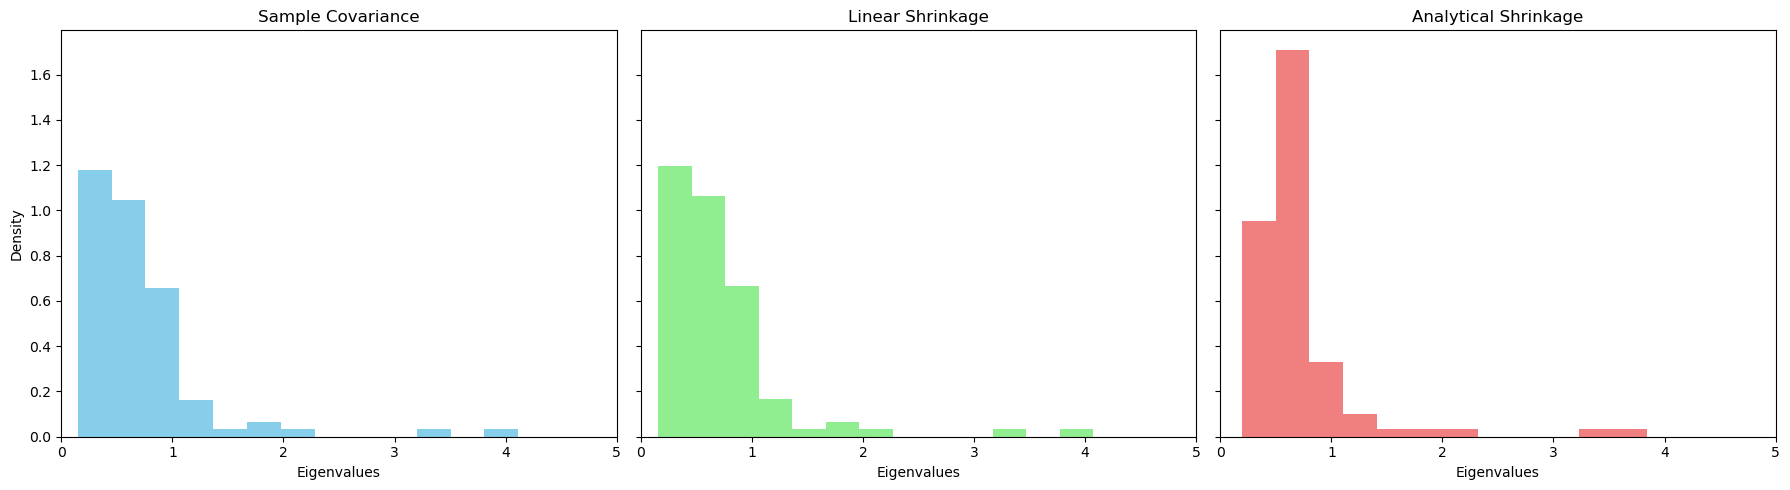

In [27]:
data100 = pd.read_csv("returns_data100.csv", index_col=0).dropna(axis=0)
devolatized_returns = data100.apply(devolatize)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # figsize sets the overall size, sharey keeps the y-axis consistent

x_li = 5

eigvals_sample100 = eigvalsh(devolatized_returns.cov())
# Plot the first histogram
axes[0].hist(eigvalsh(devolatized_returns.cov()), bins=100, density=True, color='skyblue')
axes[0].set_xlim(0, x_li)
axes[0].set_title('Sample Covariance')
axes[0].set_xlabel('Eigenvalues')
axes[0].set_ylabel('Density')

# Plot the second histogram
eigvals_linear100 = linear_shrinkage_eigvals(devolatized_returns.to_numpy())
                             
axes[1].hist( eigvals_linear100, bins=100, density=True, color='lightgreen')
axes[1].set_xlim(0, x_li)
axes[1].set_title('Linear Shrinkage')
axes[1].set_xlabel('Eigenvalues')

# Plot the third histogram

eigvals_analytical100 = analytical_shrinkage_eigvals(devolatized_returns.to_numpy())

axes[2].hist(eigvals_analytical100, bins=100, density=True, color='lightcoral')
axes[2].set_xlim(0, x_li)
axes[2].set_title('Analytical Shrinkage')
axes[2].set_xlabel('Eigenvalues')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2948.3844896108685
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3458.223656965055
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      5,   Func. Count:     39,   Neg. LLF: -2416.654935340404
Iteration:     10,   Func. Count:     68,   Neg. LLF: -2548.263214175599
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2548.278702599904
            Iterations: 14
            Function evaluations: 88
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     48,   Neg. LLF: 71863805955477.16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2059.612802692044
            Iterations: 9
            Function

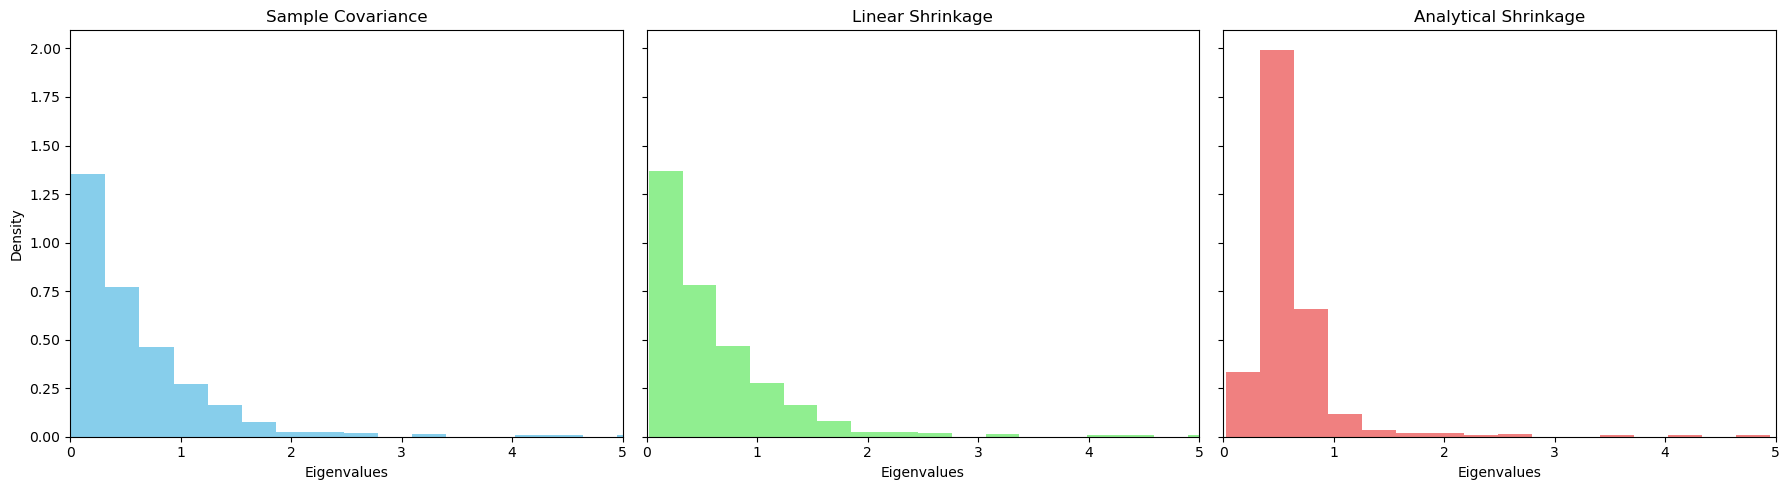

In [29]:
data500 = pd.read_csv("returns_data500.csv", index_col=0).dropna(axis=0)
devolatized_returns = data500.apply(devolatize)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # figsize sets the overall size, sharey keeps the y-axis consistent

x_li = 5
# Plot the first histogram
eigvals_sample500 = eigvalsh(devolatized_returns.cov())
axes[0].hist(eigvals_sample500, bins=500, density=True, color='skyblue')
axes[0].set_xlim(0, x_li)
axes[0].set_title('Sample Covariance')
axes[0].set_xlabel('Eigenvalues')
axes[0].set_ylabel('Density')

# Plot the second histogram
eigvals_linear500 = linear_shrinkage_eigvals(devolatized_returns.to_numpy())
axes[1].hist(eigvals_linear500, bins=500, density=True, color='lightgreen')
axes[1].set_xlim(0, x_li)
axes[1].set_title('Linear Shrinkage')
axes[1].set_xlabel('Eigenvalues')

# Plot the third histogram
eigvals_analytical500 = analytical_shrinkage_eigvals(devolatized_returns.to_numpy())
axes[2].hist(eigvals_analytical500, bins=500, density=True, color='lightcoral')
axes[2].set_xlim(0, x_li)
axes[2].set_title('Analytical Shrinkage')
axes[2].set_xlabel('Eigenvalues')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2948.3844896108685
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3458.223656965055
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      5,   Func. Count:     39,   Neg. LLF: -2416.654935340404
Iteration:     10,   Func. Count:     68,   Neg. LLF: -2548.263214175599
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2548.278702599904
            Iterations: 14
            Function evaluations: 88
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     48,   Neg. LLF: 71863805955477.16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2059.612802692044
            Iterations: 9
            Function

C:\Users\guibi\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      5,   Func. Count:     47,   Neg. LLF: 626542102.6349193
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2536.6660648294232
            Iterations: 12
            Function evaluations: 79
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4810913.174745109
Iteration:     10,   Func. Count:     78,   Neg. LLF: -2390.1695546297587
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2390.329288914948
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3113.485206070174
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3320.3648533691594
            Iterations: 8
            Funct

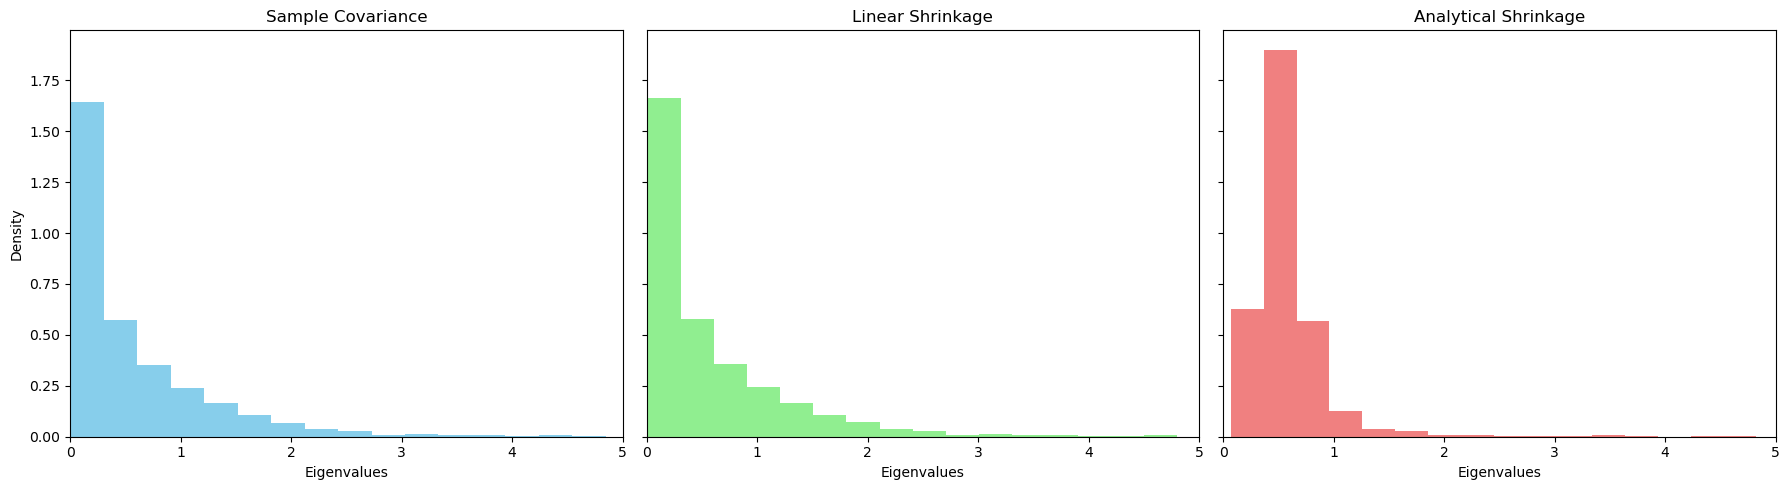

In [30]:
data1000 = pd.read_csv("returns_data1000.csv", index_col=0).dropna(axis=0)
devolatized_returns = data1000.apply(devolatize)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # figsize sets the overall size, sharey keeps the y-axis consistent

x_li = 5
# Plot the first histogram

eigvals_sample1000 = eigvalsh(devolatized_returns.cov())
axes[0].hist(eigvalsh(devolatized_returns.cov()), bins=1000, density=True, color='skyblue')
axes[0].set_xlim(0, x_li)
axes[0].set_title('Sample Covariance')
axes[0].set_xlabel('Eigenvalues')
axes[0].set_ylabel('Density')

# Plot the second histogram
eigvals_linear1000 = linear_shrinkage_eigvals(devolatized_returns.to_numpy())
axes[1].hist(eigvals_linear1000, bins=1000, density=True, color='lightgreen')
axes[1].set_xlim(0, x_li)
axes[1].set_title('Linear Shrinkage')
axes[1].set_xlabel('Eigenvalues')

# Plot the third histogram
eigvals_analytical1000 = analytical_shrinkage_eigvals(devolatized_returns.to_numpy())
axes[2].hist(eigvals_analytical1000, bins=1000, density=True, color='lightcoral')
axes[2].set_xlim(0, x_li)
axes[2].set_title('Analytical Shrinkage')
axes[2].set_xlabel('Eigenvalues')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Quantile

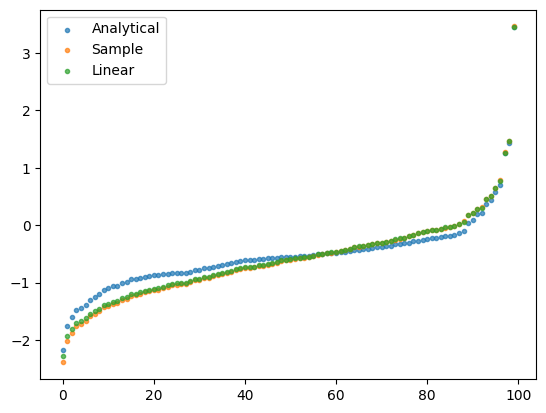

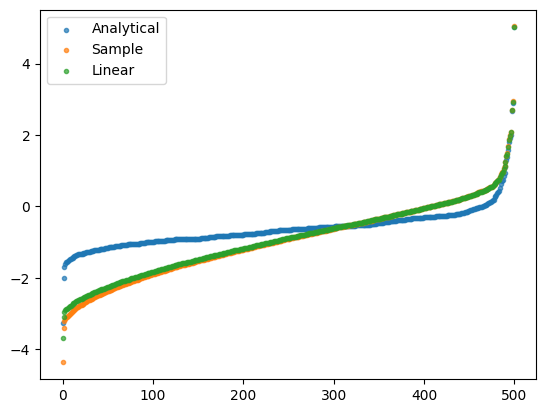

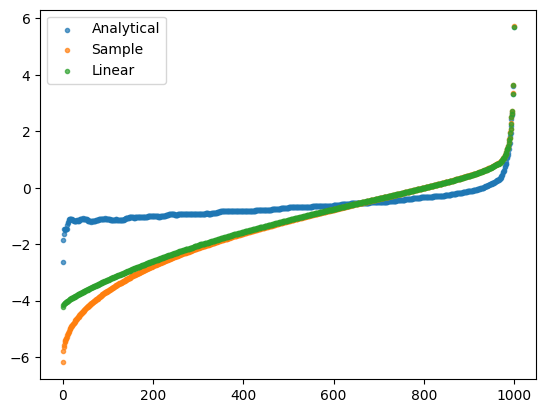

In [22]:
plt.scatter(np.arange(len(eigvals_analytical100)), np.log(eigvals_analytical100), alpha = 0.7, marker = '.', label = 'Analytical' )
plt.scatter(np.arange(len(eigvals_sample100)), np.log(eigvals_sample100),alpha = 0.7,  marker = '.', label = 'Sample')
plt.scatter(np.arange(len(eigvals_linear100)), np.log(eigvals_linear100), alpha = 0.7 , marker = '.', label = 'Linear')
plt.legend()
plt.show()

plt.scatter(np.arange(len(eigvals_analytical500)), np.log(eigvals_analytical500), alpha = 0.7, marker = '.', label = 'Analytical' )
plt.scatter(np.arange(len(eigvals_sample500)), np.log(eigvals_sample500),alpha = 0.7,  marker = '.', label = 'Sample')
plt.scatter(np.arange(len(eigvals_linear500)), np.log(eigvals_linear500), alpha = 0.7 , marker = '.', label = 'Linear')
plt.legend()
plt.show()

plt.scatter(np.arange(len(eigvals_analytical1000)), np.log(eigvals_analytical1000), alpha = 0.7, marker = '.', label = 'Analytical' )
plt.scatter(np.arange(len(eigvals_sample1000)), np.log(eigvals_sample1000),alpha = 0.7,  marker = '.', label = 'Sample')
plt.scatter(np.arange(len(eigvals_linear1000)), np.log(eigvals_linear1000), alpha = 0.7 , marker = '.', label = 'Linear')
plt.legend()
plt.show()

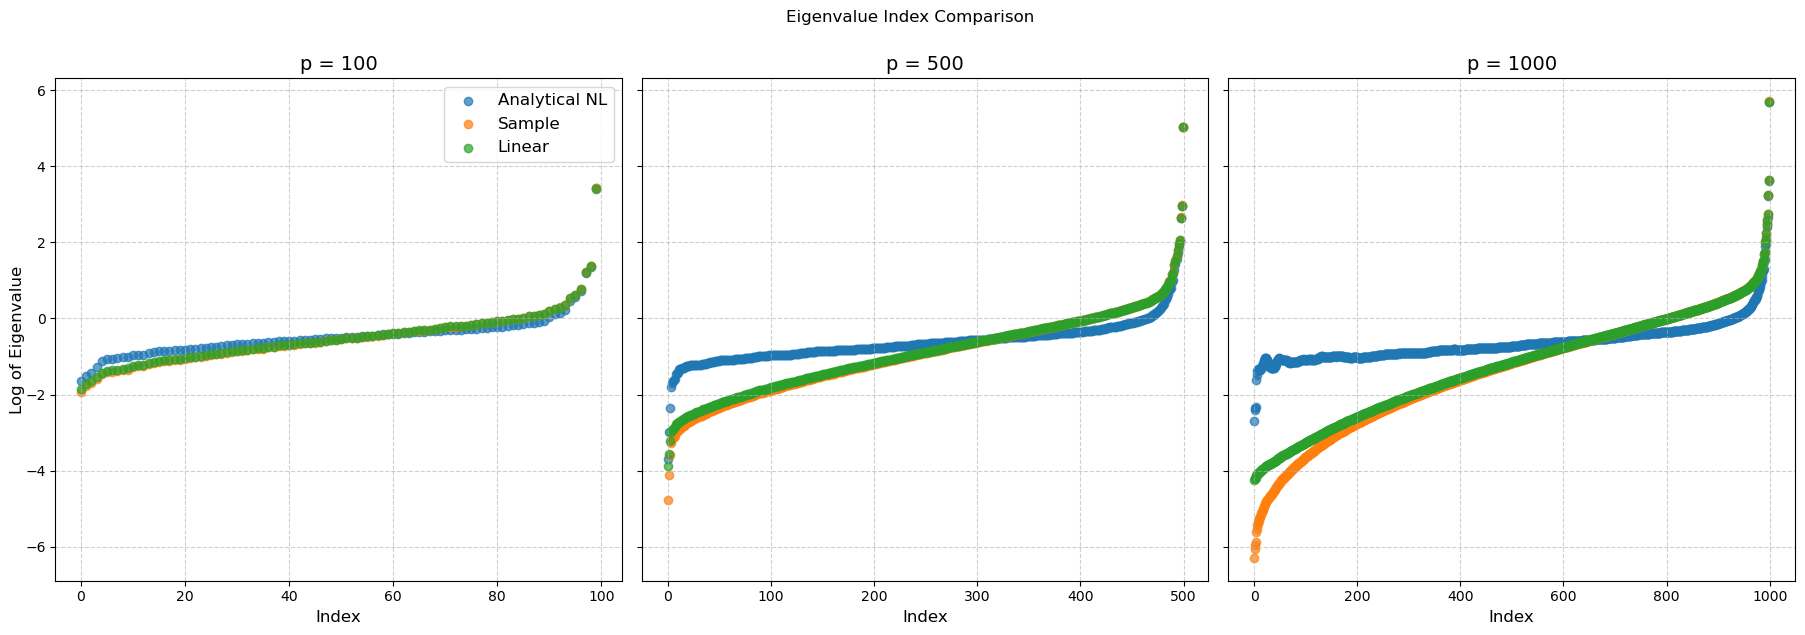

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

def plot_eigenvalues(ax, eigvals_analytical, eigvals_sample, eigvals_linear, n):
    ax.scatter(np.arange(len(eigvals_analytical)), np.log(eigvals_analytical), 
               alpha=0.7, marker='o', label='Analytical NL', color='tab:blue')
    ax.scatter(np.arange(len(eigvals_sample)), np.log(eigvals_sample), 
               alpha=0.7, marker='o', label='Sample', color='tab:orange')
    ax.scatter(np.arange(len(eigvals_linear)), np.log(eigvals_linear), 
               alpha=0.7, marker='o', label='Linear', color='tab:green')
    
    ax.set_title(f'p = {n}', fontsize=14)
    ax.set_xlabel('Index', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Plot for different sample sizes
plot_eigenvalues(axs[0], eigvals_analytical100, eigvals_sample100, eigvals_linear100, 100)
plot_eigenvalues(axs[1], eigvals_analytical500, eigvals_sample500, eigvals_linear500, 500)
plot_eigenvalues(axs[2], eigvals_analytical1000, eigvals_sample1000, eigvals_linear1000, 1000)

# Set shared y-label
fig.text(0.0, 0.5, 'Log of Eigenvalue', va='center', rotation='vertical', fontsize=12)

# Add a legend to the first subplot
axs[0].legend(fontsize=12)

plt.tight_layout()
plt.suptitle("Eigenvalue Index Comparison", y = 1.05)
plt.show()

# Covariances in Real Data

In [70]:
dcc1000_results = np.load("dcc_res_1000\dcc1000.npy").swapaxes(0, 2)
#dcc1000_results_corr = np.load("dcc_res_1000\dcc_corr1000.npy").swapaxes(0, 2)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\guibi\AppData\Local\Temp\ipykernel_23616\3140124334.py:1: SyntaxWarning: invalid escape sequence '\d'
  dcc1000_results = np.load("dcc_res_1000\dcc1000.npy").swapaxes(0, 2)


In [52]:
print(np.where(data1000.columns == 'AAPL'))
print(np.where(data1000.columns == 'GOOG'))
print(np.where(data1000.columns == 'BAC'))
print(np.where(data1000.columns == 'GS'))

(array([118], dtype=int64),)
(array([601], dtype=int64),)
(array([55], dtype=int64),)
(array([12], dtype=int64),)


C:\Users\guibi\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


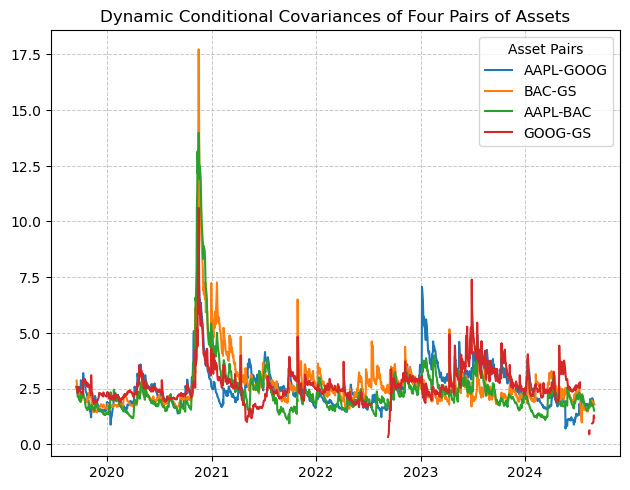

In [72]:
corr_data = pd.DataFrame({'AAPL-GOOG' : dcc1000_results[:,118,797],
                          'BAC-GS' : dcc1000_results[:,55,960],
                          'AAPL-BAC' : dcc1000_results[:,118,55],
                          'GOOG-GS' : dcc1000_results[:,797,960]})
corr_data.index = pd.to_datetime(data1000.index)

plt.plot(np.sqrt(corr_data) * 250, label = corr_data.columns)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Asset Pairs')
plt.title("Dynamic Conditional Covariances of Four Pairs of Assets")
plt.show()

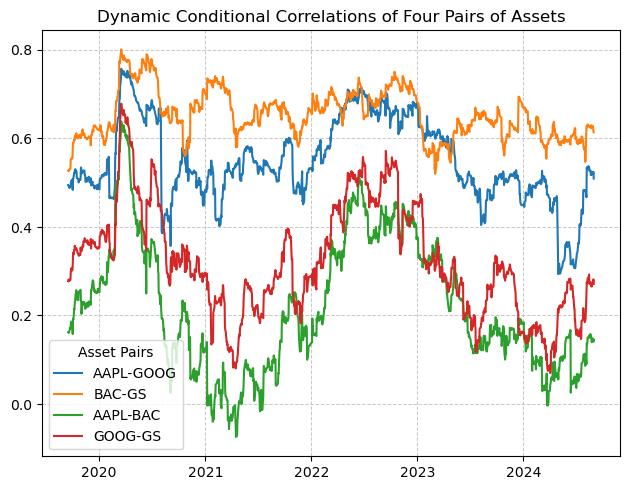

In [65]:
corr_data = pd.DataFrame({'AAPL-GOOG' : dcc1000_results[:,118,797],
                          'BAC-GS' : dcc1000_results[:,55,960],
                          'AAPL-BAC' : dcc1000_results[:,118,55],
                          'GOOG-GS' : dcc1000_results[:,797,960]})
corr_data.index = pd.to_datetime(data1000.index)

plt.plot(corr_data, label = corr_data.columns)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Asset Pairs')
plt.title("Dynamic Conditional Correlations of Four Pairs of Assets")
plt.show()

In [5]:
#dcc_long_res = np.load("dcc_res_long//dcc_corr750long.npy").swapaxes(0, 2)
dcc_long_res = np.load("dcc_res_long//dcc750long.npy").swapaxes(0, 2)

In [6]:
long750_returns = pd.read_csv("levels_data_long_750.csv", index_col=0)
long750_returns.index = pd.to_datetime(long750_returns.index)

In [7]:
print(np.where(long750_returns.columns == "BAC"))
print(np.where(long750_returns.columns == "WFC"))
print(np.where(long750_returns.columns == "NVDA"))
print(np.where(long750_returns.columns == "AMD"))

(array([615], dtype=int64),)
(array([430], dtype=int64),)
(array([331], dtype=int64),)
(array([2], dtype=int64),)


C:\Users\guibi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


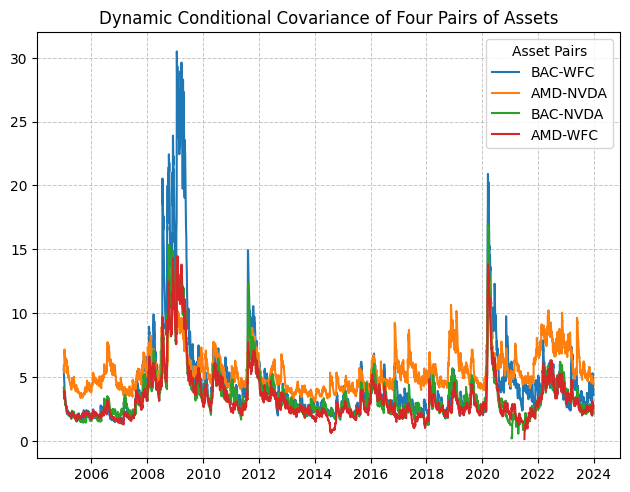

In [9]:
corr_data_long = pd.DataFrame({'BAC-WFC' : dcc_long_res[:,615,430],
                          'AMD-NVDA' : dcc_long_res[:,331,2],
                          'BAC-NVDA' : dcc_long_res[:,615,331],
                          'AMD-WFC' : dcc_long_res[:,2,430]})
corr_data_long.index = pd.to_datetime(long750_returns.index)[1:]

plt.plot(np.sqrt(corr_data_long)*250, label = corr_data_long.columns)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Asset Pairs')
plt.title("Dynamic Conditional Covariance of Four Pairs of Assets")
plt.show()

### Portfolio Analysis

In [12]:
levels750long = pd.read_csv("levels_data_long_750.csv", index_col=0)
ana_dcc_port = np.load("min_var_analysis//analytical.npy").T

In [44]:
lin_dcc_port = np.load("min_var_analysis//linear.npy").T
sample_dcc_port = np.load("min_var_analysis//sample.npy").T

In [60]:
gains_analytical_in_sample = np.exp((data750long.to_numpy() * ana_dcc_port).sum(axis = 1).cumsum())
gains_linear_in_sample = np.exp((data750long.to_numpy() * lin_dcc_port).sum(axis = 1).cumsum())
gains_sample_in_sample = np.exp((data750long.to_numpy() * sample_dcc_port).sum(axis = 1).cumsum())
gains_uniform_in_sample = np.exp((data750long.to_numpy() * np.ones_like(lin_dcc_port)/750).sum(axis = 1).cumsum())


In [61]:
data_ports = pd.DataFrame({"linear" : gains_linear_in_sample, 
                           "analytical" : gains_analytical_in_sample,
                          "uniform" : gains_uniform_in_sample,
                          "sample" : gains_sample_in_sample})
data_ports.index = pd.to_datetime(data750long.index)

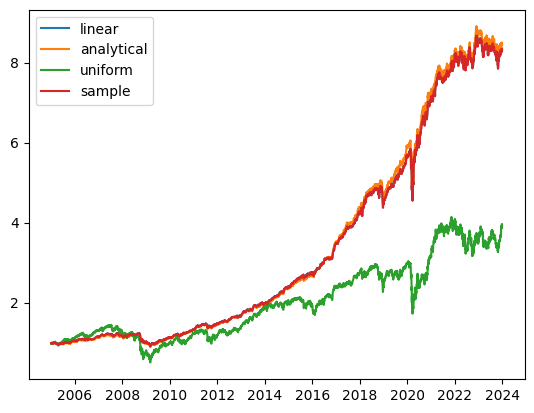

In [62]:
plt.plot(data_ports, label = data_ports.columns)
plt.legend()
plt.show()

In [65]:
anal_dcc_port_oos = np.load("markowitz_analytical.npy").T
gains_analytical_oos = np.exp((data750long.to_numpy()[-501:] * anal_dcc_port_oos).sum(axis = 1).cumsum())
gains_uniform_in_sample_short = np.exp((data750long.to_numpy()[-501:] * np.ones_like(data750long.to_numpy()[-501:])/750).sum(axis = 1).cumsum())


In [79]:
sp500 = yf.download("^GSPC", start='2022-01-03', end='2024-01-01')['Close']
sp500 /= sp500[0]

[*********************100%%**********************]  1 of 1 completed


In [80]:
sp500

Date
2022-01-03    1.000000
2022-01-04    0.999370
2022-01-05    0.979990
2022-01-06    0.979045
2022-01-07    0.975080
                ...   
2023-12-22    0.991258
2023-12-26    0.995453
2023-12-27    0.996877
2023-12-28    0.997246
2023-12-29    0.994427
Name: Close, Length: 501, dtype: float64

In [88]:
datashort = pd.DataFrame({"Analytical NL-DCC" : gains_analytical_oos, "Uniform Portfolio" : gains_uniform_in_sample_short, "SP500" : sp500})
datashort.index = pd.to_datetime(sp500.index)

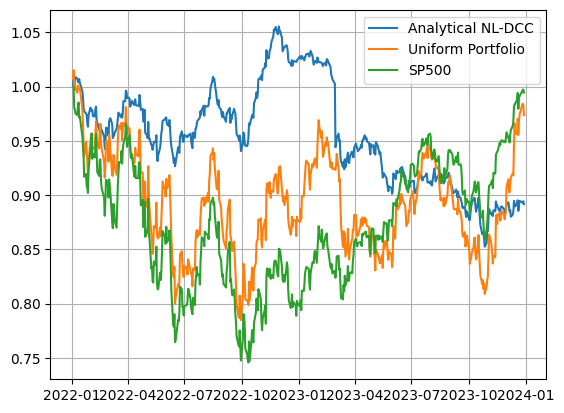

In [89]:
plt.plot(datashort, label = datashort.columns)
plt.legend()
plt.grid()
plt.show()

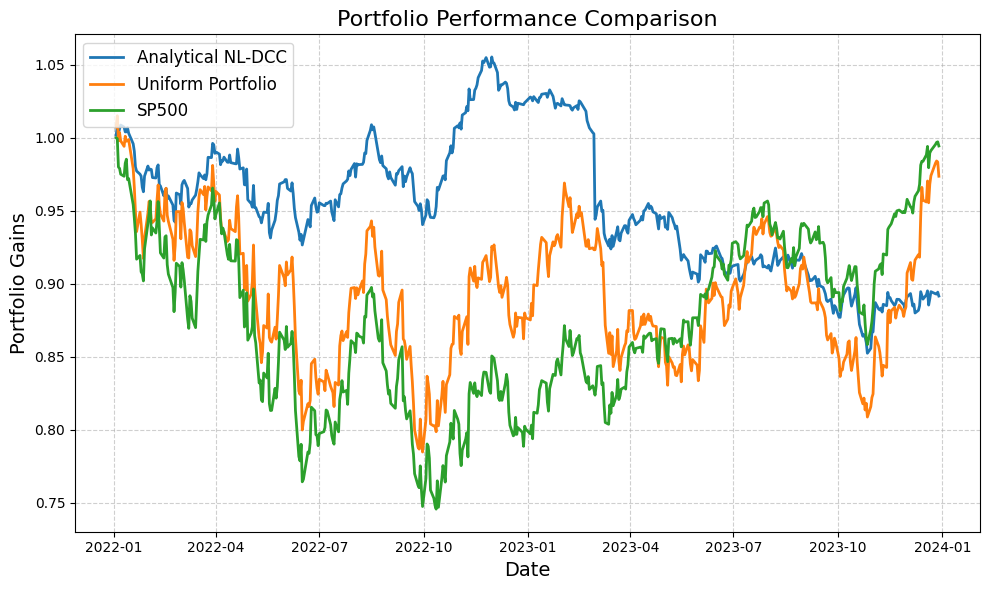

In [92]:
plt.figure(figsize=(10, 6))

# Customize lines with different styles and colors
plt.plot(datashort, linewidth=2.0)

# Adding labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Gains', fontsize=14)
plt.title('Portfolio Performance Comparison', fontsize=16)

# Customizing the legend
plt.legend(datashort.columns, loc='upper left', fontsize=12, frameon=True)

# Customizing the grid
plt.grid(True, linestyle='--', alpha=0.6)

# Improving overall layout
plt.tight_layout()

# Show the plot
plt.show()

In [97]:
portfolio = pd.DataFrame(anal_dcc_port_oos)
portfolio.columns = data750long.columns

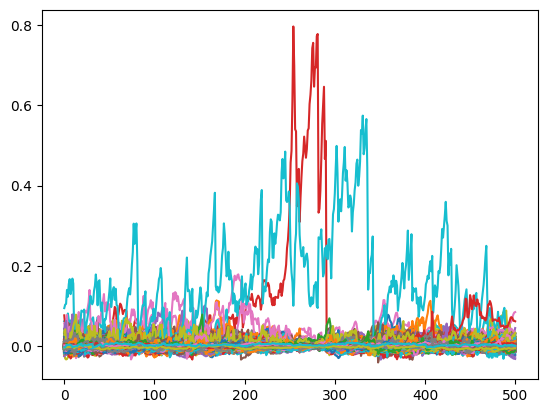

In [96]:
plt.plot(portfolio)
plt.show()

### Markowitz Portfolio Long 

In [114]:
analytical100port = np.load("min_var_analysis/analytical100.npy")
#linear100port = np.load("min_var_analysis/linear100.npy")

In [122]:
returns100long = pd.read_csv("returns_data_long_100.csv", index_col=0) #1931

In [140]:
returns100long

,RL,RF,TMO,INTC,SPGI,EW,BALL,REG,STX,HD,...,NSC,ALL,LULU,CI,PAYX,CRM,AKAM,MAA,MOH,COO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00+00:00,-0.028923,-0.034853,-0.013832,-0.011341,-0.017867,0.000470,-0.022054,0.011201,-0.005316,-0.021204,...,-0.025611,-0.020022,0.011141,-0.017363,0.001729,-0.018227,-0.020929,-0.003816,-0.019257,-0.007751
2015-01-06 00:00:00+00:00,-0.019701,-0.034071,-0.009383,-0.018813,-0.014573,-0.005965,-0.017056,0.007145,-0.027949,-0.003066,...,-0.032383,-0.000728,-0.006994,0.003950,-0.007150,-0.016816,-0.020717,0.017251,-0.021024,-0.014219
2015-01-07 00:00:00+00:00,0.024747,0.006097,0.029517,0.020758,0.013194,0.023190,0.008791,0.025576,0.006400,0.033700,...,0.000000,0.016319,0.036747,0.023187,0.018100,-0.004731,-0.008442,0.012362,0.001984,0.031944
2015-01-08 00:00:00+00:00,-0.001176,0.015084,0.010340,0.018430,0.008928,0.023942,0.017056,-0.003550,0.017888,0.021883,...,0.009566,0.019013,0.024333,0.049689,0.015468,0.028742,0.023167,0.002557,0.020595,0.004060
2015-01-09 00:00:00+00:00,-0.014553,-0.029369,-0.004000,0.001906,-0.008583,0.000075,-0.019927,-0.002077,0.015318,-0.017297,...,-0.007916,-0.010313,-0.007477,-0.010409,-0.008870,-0.007366,-0.012914,0.006236,-0.012699,-0.006282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26 00:00:00+00:00,-0.019901,-0.000877,-0.000875,-0.020163,0.002853,-0.030512,-0.003413,-0.002383,0.003347,-0.003948,...,0.007122,0.014192,0.011514,-0.000141,0.001460,0.004837,-0.008283,0.008329,0.004242,-0.001798
2024-08-27 00:00:00+00:00,0.007625,-0.001317,0.007911,-0.002985,0.008505,0.012719,-0.004361,0.000281,-0.039427,-0.002489,...,0.026546,0.011134,-0.001769,-0.000141,-0.000692,-0.004079,0.003164,0.014894,0.007230,-0.001059
2024-08-28 00:00:00+00:00,-0.017431,0.009620,0.004479,-0.023186,-0.000238,-0.014174,-0.008938,0.005457,-0.014603,-0.001314,...,0.005609,0.010317,-0.046611,0.011351,-0.000923,-0.020265,-0.012215,0.007458,0.007434,0.002012


In [124]:
2431 - 500

1931

In [130]:
gains_analytical100_oos = np.exp((returns100long.to_numpy()[-days:] * analytical100port).sum(axis = 1).cumsum())
#gains_linear100_oos = np.exp((returns100long.to_numpy()[-days:] * linear100port).sum(axis = 1).cumsum())
gains_uniform_in_sample_100 = np.exp((returns100long.to_numpy()[-days:] * np.ones_like(returns100long.to_numpy()[-days:])/100).sum(axis = 1).cumsum())

In [132]:
sp500 = yf.download("^GSPC", start='2016-12-29', end='2024-09-01')['Close']
#sp500 = sp500[-days:]
sp500 /= sp500[0]

[*********************100%***********************]  1 of 1 completed
C:\Users\guibi\AppData\Local\Temp\ipykernel_23616\4034416324.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sp500 /= sp500[0]


In [134]:
datashort100 = pd.DataFrame({"Analytical NL-DCC" : gains_analytical100_oos,
                             #"Linear-DCC" : gains_linear100_oos,
                             "Uniform Portfolio" : gains_uniform_in_sample_100,
                             "SP500" : sp500})
datashort100.index = pd.to_datetime(sp500.index)

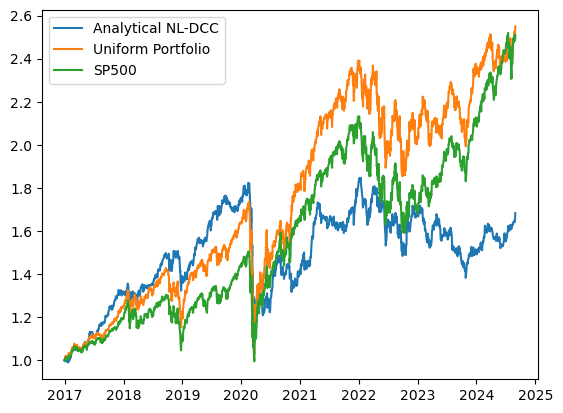

In [136]:
plt.plot(datashort100, label = datashort100.columns)
plt.legend()
plt.show()

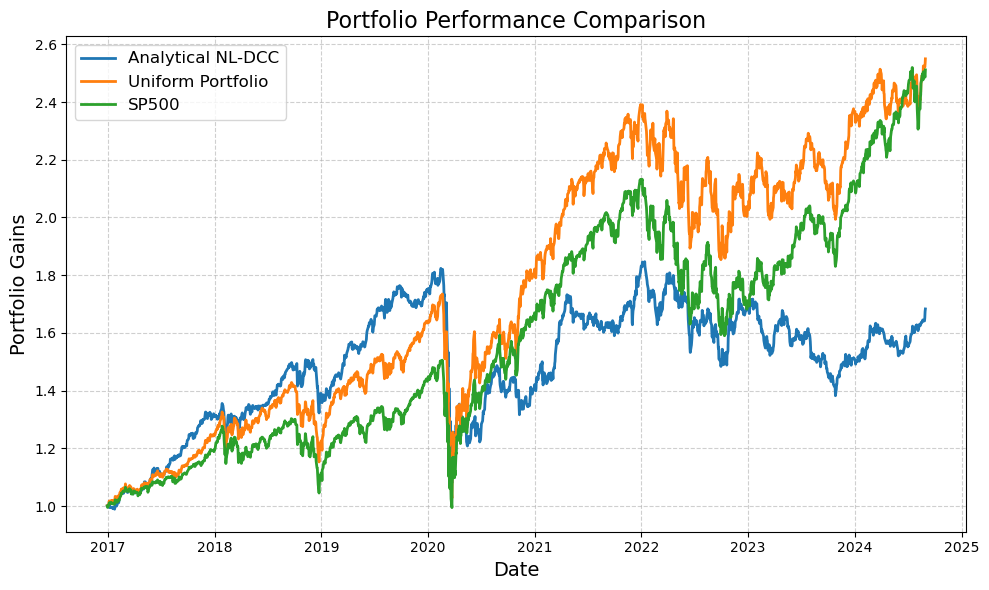

In [138]:
plt.figure(figsize=(10, 6))

# Customize lines with different styles and colors
plt.plot(datashort100, linewidth=2.0)

# Adding labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Gains', fontsize=14)
plt.title('Portfolio Performance Comparison', fontsize=16)

# Customizing the legend
plt.legend(datashort100.columns, loc='upper left', fontsize=12, frameon=True)

# Customizing the grid
plt.grid(True, linestyle='--', alpha=0.6)

# Improving overall layout
plt.tight_layout()

# Show the plot
plt.show()

In [161]:
linear100port.shape

(1762, 100)